You might need to install this on your system:

apt-get install python3-opencv git

In [1]:
import os

#"""
# !rm k -r
if not os.path.isdir('k'):
 !git clone -b development12 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
#"""
!cd k && pip install .

Already up to date.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.4-py3-none-any.whl size=56793 sha256=f695a0d48d598db7b4828b0409c85aec937712359e82df4e0f55260db51c308d
  Stored in directory: /tmp/pip-ephem-wheel-cache-3bc0fmfi/wheels/c1/8a/57/56dbba25eff58e52e5365435c4fa102ad8d6f9787d3b4db13a
Successfully built cai
  Attempting uninstall: cai
    Found existing installation: cai 0.1.4
    Uninstalling cai-0.1.4:
      Successfully uninstalled cai-0.1.4


In [2]:
import cai.layers
import cai.datasets
import cai.models
import cai.densenet
import cai.efficientnet
import numpy as np
from tensorflow import keras
from tensorflow.keras import mixed_precision
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

Tensorflow version: 2.6.0
Keras version: 2.6.0
CPU cores: 8
RAM: 54.76702208 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Tue Nov  9 13:02:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    52W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
dataset=tf.keras.datasets.cifar10
verbose=True
lab=False
bipolar=False
base_model_name='JP30B28'
x_train, y_train, x_test, y_test = cai.datasets.load_dataset(dataset, verbose=verbose, lab=lab, bipolar=bipolar, base_model_name=base_model_name)
print(x_train.shape)
print(y_train.shape)

train shape (50000, 32, 32, 3)
test shape (10000, 32, 32, 3)
Original channel  0  min: 0.0  max: 255.0
Original channel  1  min: 0.0  max: 255.0
Original channel  2  min: 0.0  max: 255.0
Loading RGB.
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0
(50000, 32, 32, 3)
(50000, 10)


In [7]:
num_classes = 10
batch_size = 64
epochs = 50
target_size_x = 32
target_size_y = 32
seed = 12

In [8]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

In [9]:
train_datagen = cai.util.create_image_generator(validation_split=0.1, rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.0)
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

In [10]:
def work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_accuracy'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [2, 13]: #
      basefilename = '/content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      model = cai.efficientnet.kEfficientNetB0(
        include_top=True,
        skip_stride_cnt=3,
        input_shape=input_shape,
        classes=num_classes,
        kType=kType)
      
      optimizer = keras.optimizers.RMSprop()
      optimizer = mixed_precision.LossScaleOptimizer(optimizer)
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary()
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            save_freq='epoch')

      if (run_fit): 
            train_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed,
                subset='training'
            )
            validation_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed,
                subset='validation'
            )
            history = model.fit(
              x = train_flow,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=validation_flow,
              callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
              workers=cpus_num,
              max_queue_size=128
            )
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Epochs")
            plt.ylim([0,1])
            plt.plot(history.history["accuracy"])
            plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow(
            x_test, y_test,
            batch_size=batch_size,
            shuffle=True,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        model = cai.models.load_kereas_model(best_result_file_name)
        pred_y = model.predict(x_test)
        print("Predicted Shape:", pred_y.shape)
        pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
        test_classes_y = np.array(list(np.argmax(y_test, axis=1)))
        print("Pred classes shape:",pred_classes_y.shape)
        print("Test classes shape:",test_classes_y.shape)
        report = classification_report(test_classes_y, pred_classes_y, digits=4)
        print(report)
      print('Finished: '+basefilename)

# Show Models

In [11]:
work_on_efficientnet(show_model=True, run_fit=False, test_results=False)

Running: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2
Model: "kEffNet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
k_stem_conv_pad (ZeroPadding2D) (None, 33, 33, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
k_stem_conv (Conv2D)            (None, 31, 31, 32)   864         k_stem_conv_pad[0][0]            
__________________________________________________________________________________________________
k_stem_bn (BatchNormalization)  (None, 31, 31, 32)   128         k_stem_conv[0][0]                
___________________

# Fitting

Running: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2
Epoch 1/50
704/704 [==============================] - 289s 324ms/step - loss: 2.3518 - accuracy: 0.2361 - val_loss: 1.9592 - val_accuracy: 0.2974

Epoch 00001: val_accuracy improved from -inf to 0.29740, saving model to /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
704/704 [==============================] - 212s 301ms/step - loss: 1.8852 - accuracy: 0.3162 - val_loss: 1.9814 - val_accuracy: 0.3216

Epoch 00002: val_accuracy improved from 0.29740 to 0.32160, saving model to /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2-best_result.hdf5
Epoch 3/50
704/704 [==============================] - 212s 300ms/step - loss: 1.5799 - accuracy: 0.4234 - val_loss: 1.9142 - val_accuracy: 0.3884

Epoch 00003: val_accuracy improved from 0.32160 to 0.38840, saving model to /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2-best_result.hdf5
Epoch 4/50
704/704 [==============================] - 212s 300ms/step - loss: 1.3341 - accuracy: 0.5230 - val_loss: 1.4405 - val_accuracy: 0.5340

Epoch 00004: val_accuracy improved from 0.38840 to 0.53400, saving model to /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2-best_result.hdf5
Epoch 5/50
704/704 [==============================] - 212s 301ms/step - loss: 1.1742 - accuracy: 

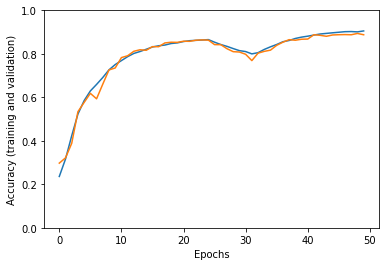

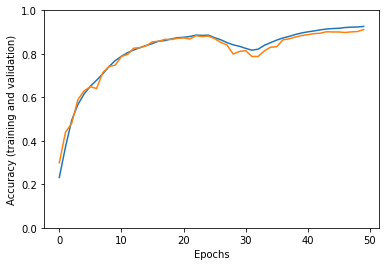

In [12]:
work_on_efficientnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [13]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True)

Running: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2
Best Model Results: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2-best_result.hdf5
157/157 [==============================] - 20s 67ms/step - loss: 0.2307 - accuracy: 0.9246
loss 0.23065903782844543
acc 0.9246000051498413
Finished: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2
Running: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-13
Best Model Results: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-13-best_result.hdf5
157/157 [==============================] - 19s 61ms/step - loss: 0.2137 - accuracy: 0.9361
loss 0.21367250382900238
acc 0.9361000061035156
Finished: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-13


In [14]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=True)

Running: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2
Best Model Results: /content/drive/MyDrive/output/JP30B28-EfficientNet-CIFAR10-2-best_result.hdf5
157/157 [==============================] - 20s 67ms/step - loss: 0.2307 - accuracy: 0.9246
loss 0.23065903782844543
acc 0.9246000051498413
Predicted Shape: (10000, 10)
Pred classes shape: (10000,)
Test classes shape: (10000,)
              precision    recall  f1-score   support

           0     0.9147    0.9440    0.9291      1000
           1     0.9323    0.9780    0.9546      1000
           2     0.9189    0.8950    0.9068      1000
           3     0.8621    0.8380    0.8499      1000
           4     0.9210    0.9440    0.9323      1000
           5     0.9108    0.8580    0.8836      1000
           6     0.9147    0.9650    0.9392      1000
           7     0.9689    0.9350    0.9517      1000
           8     0.9576    0.9490    0.9533      1000
           9     0.9437    0.9390    0.9414      1000

    accura